In [9]:
from os import listdir
from os.path import isfile, join

import loop_tool as lt
import numpy as np
from matplotlib import pyplot as plt

from tqdm import tqdm
# import time
from IPython import display
from ipywidgets import Output


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import pdb
device = 'cpu'

In [10]:
def get_stride_tensor(stride_freq_pairs):
    bucket_num = 32
    stride_freq_vector = [0] * bucket_num
    total_freq = sum([ x[1] for x in stride_freq_pairs] )
    for stride, freq in stride_freq_pairs:
        bucket_id = int(np.log2(stride))
        stride_freq_vector[bucket_id] += freq/total_freq # Normalize freq

    return torch.tensor(stride_freq_vector)


In [11]:
class LoopToolDataset(Dataset):
    def __init__(
        self,
        data_path,
    ):
        self.data_path = data_path
        self.data = []
        self.process()

    def process(self):
        file_paths = [join(self.data_path, f) for f in listdir(self.data_path)]

        for file_path in file_paths:
            with open(file_path) as file:
                file_lines = file.readlines()
                ir = lt.deserialize(''.join(file_lines[:-1]))
                tree = lt.LoopTree(ir)
                tensor = get_stride_tensor(tree.ir.get_stride_frequency())
                flops = float(file_lines[-1])
                self.data.append([tensor, flops])


    def __getitem__(self, i):
        return self.data[i][0], torch.tensor(self.data[i][1] / 1e9)


    def __len__(self):    
        return len(self.data)

In [12]:
loop_tool_dataset = LoopToolDataset(data_path='small')

In [13]:
test_size = len(loop_tool_dataset.data) // 5
train_size = len(loop_tool_dataset.data) - test_size

print(f'Dataset training validation = {train_size}, {test_size}')
train_set, test_set = torch.utils.data.random_split(loop_tool_dataset, [train_size, test_size])

batch_size = 10
trainLoad = DataLoader(train_set,batch_size=batch_size,shuffle=True)
testLoad = DataLoader(test_set,batch_size=batch_size,shuffle=True)

Dataset training validation = 800, 200


In [22]:
class SmallNet(nn.Module):
    def __init__(self, in_size, out_size, hidden_size, dropout=0):
        super(SmallNet,self).__init__()
        self.l1 = nn.Linear(in_size,hidden_size)
        self.l2 = nn.Linear(hidden_size,hidden_size)
        self.l3 = nn.Linear(hidden_size,hidden_size)
        self.l7 = nn.Linear(hidden_size,out_size)
        # self.softmax = nn.Softmax(dim=1)
        # self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = self.l7(x)
        return x

In [23]:
model_path = "model_weights.pt"
model = SmallNet(in_size=32, out_size=1, hidden_size=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = nn.HuberLoss()



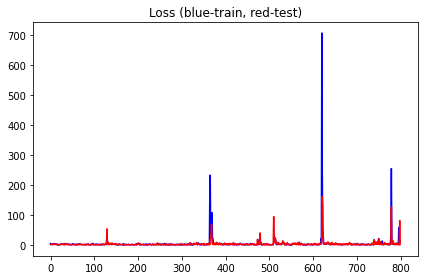

100%|██████████| 100/100 [02:21<00:00,  1.41s/it]


In [25]:
train_losses = []
test_losses = []
num_epochs = 100
test_every = 10

out = Output()
display.display(out)

for epoch in tqdm(range(num_epochs)):
    model.train()
    
    for state, cost in trainLoad:
        train_losses_batch = []

        for state, cost in zip(state, cost):
            
            pred_cost = model(state)[0]
            train_loss = criterion(pred_cost, cost)
            train_losses_batch.append(train_loss.item())

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            

        if epoch % test_every == 0:
            with torch.no_grad():
                model.eval()
                test_losses_batch = []
                for state, cost in testLoad:
                    for state, cost in zip(state, cost):

                        pred_cost = model(state)[0]
                        test_loss = criterion(pred_cost, cost )
                        test_losses_batch.append(test_loss.item())

            train_losses.append(np.mean(train_losses_batch))
            test_losses.append(np.mean(test_losses_batch))
            # torch.save(model.state_dict(), model_path)

            with out:
                display.clear_output(wait=True)
                plt.title('Loss (blue-train, red-test)')
                plt.plot(train_losses, color='blue')
                plt.plot(test_losses, color='red')

                plt.tight_layout()
                plt.show()


    
    


In [17]:
plt.show()